In [2]:
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
import os
import warnings
from aicsimageio import transforms, AICSImage
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

In [3]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


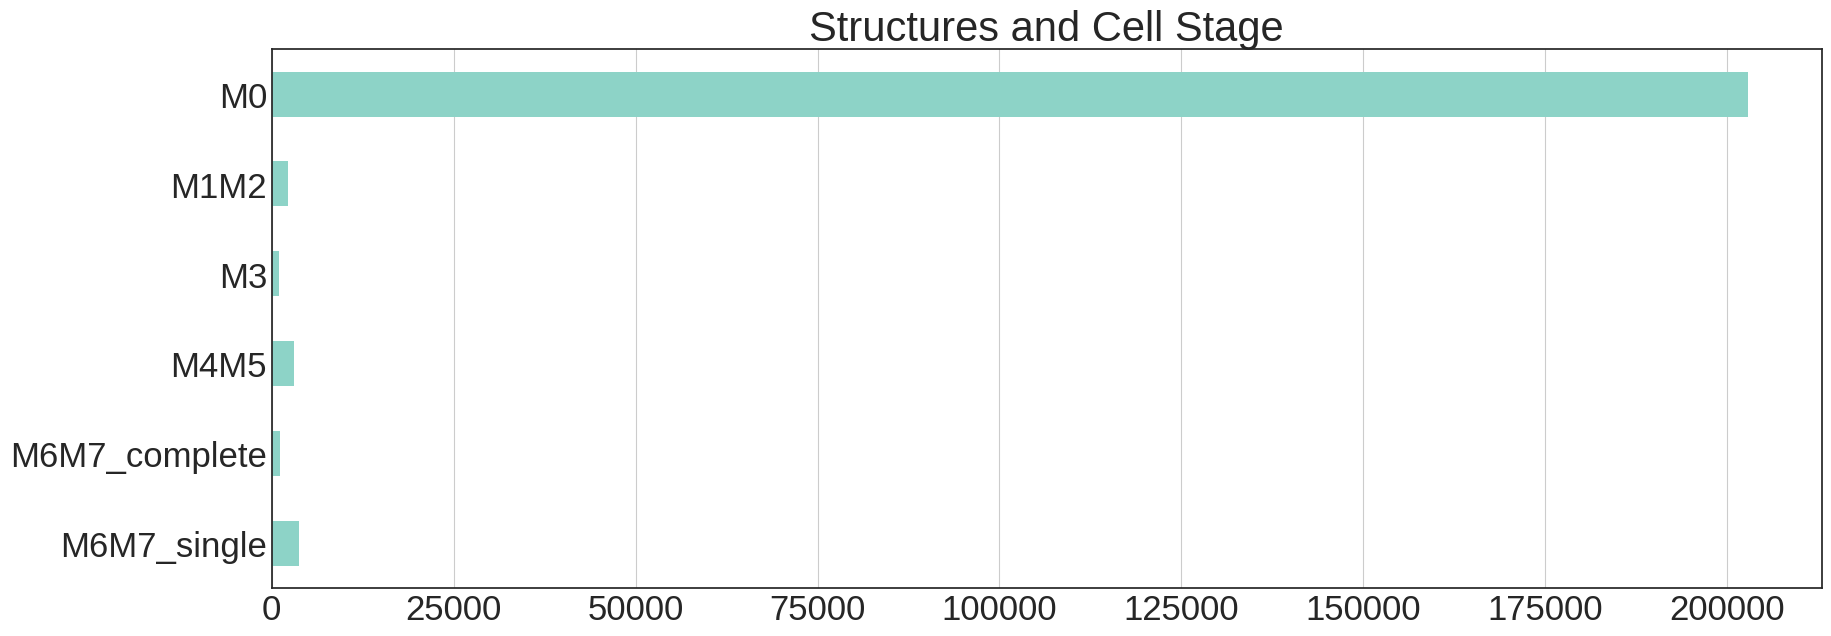

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

In [41]:
#From Chapter 5
#loading library, making path for 
from serotiny.transforms.dataframe.transforms import split_dataframe
Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

# Sample n cells per group
n = 2000 # number of cells per mitotic class
cells_to_include=[]
for name, group in df.groupby('cell_stage'):    
    sampled_group = group.sample(min([n,len(group)]), random_state=0)
    cells_to_include.append(sampled_group)
df_mitocells = pd.concat(cells_to_include).reset_index(drop=True)

#print(cells_to_include[0])

# Discarding all the M6M7_single cells
df_mitocells = df_mitocells.drop(df_mitocells[df_mitocells['cell_stage']=='M6M7_single'].index)

# Add the train, test and validate split
df_mitocells = split_dataframe(dataframe=df_mitocells, train_frac=0.7, val_frac=0.2, return_splits=False)

df_mitocells['cell_stage_int'] = pd.factorize(df_mitocells.cell_stage)[0]

print(np.unique(df_mitocells.cell_stage_int))

df_mitocells.to_csv("/home/aicsuser/serotiny_data/mitocells.csv") 
print(f"Number of cells: {len(df_mitocells)}")
print(f"Number of columns: {len(df_mitocells.columns)}")

[0 1 2 3 4]
Number of cells: 8179
Number of columns: 79


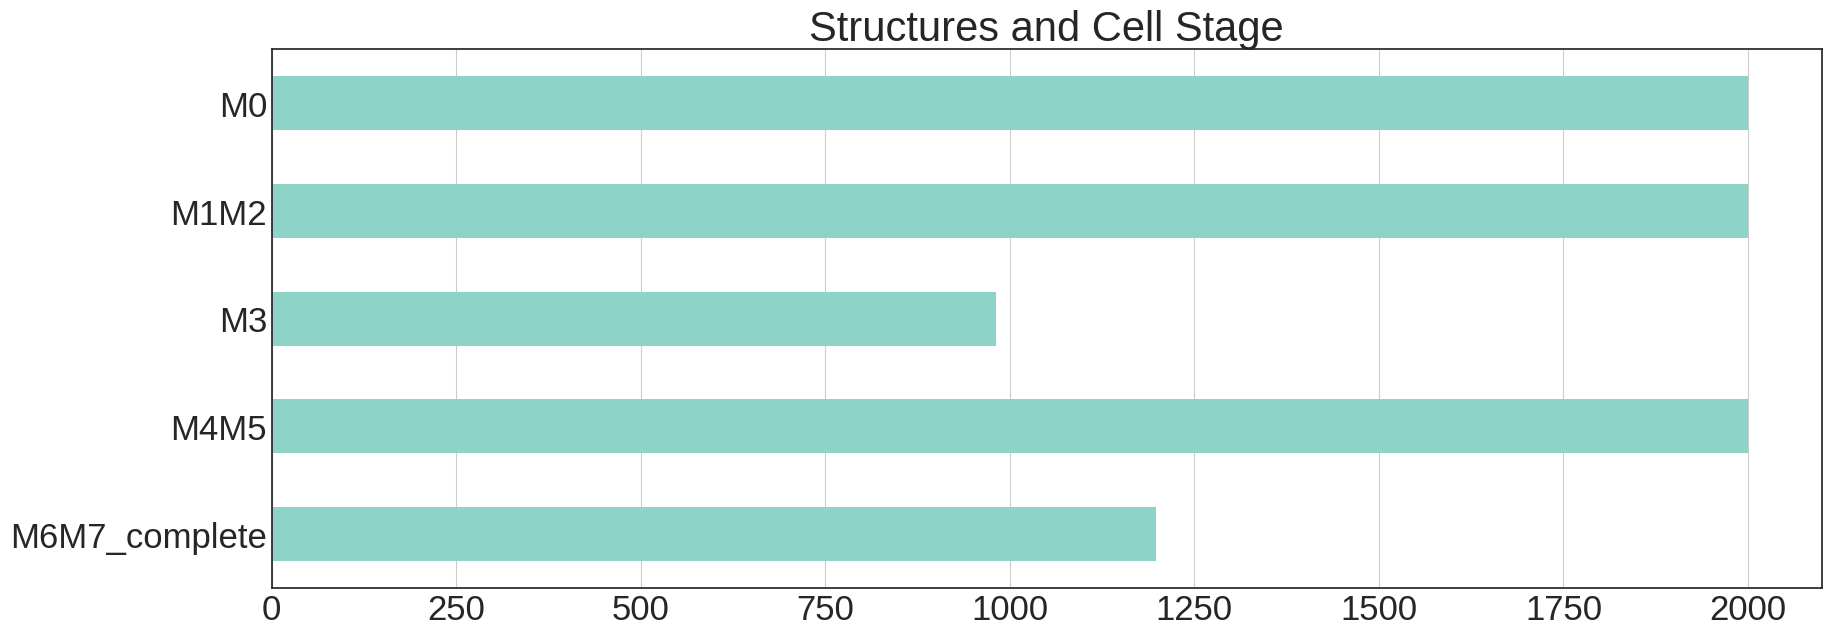

cell_stage
M0               2000
M1M2             2000
M3                981
M4M5             2000
M6M7_complete    1198
dtype: int64


In [42]:
# The bar plot again
%matplotlib inline
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df_mitocells, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()
print(table)

In [7]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

In [8]:
# we need the commands we type to be ran from the serotiny project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

In [43]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

In [44]:
run_name = f"yf_bfdna_zproj_{now_str()}"
print(run_name)

!serotiny train \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow.experiment_name=cytodata_yf \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=5

yf_bfdna_zproj_20221020_031833
[2022-10-20 03:18:37,716][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 03:18:37,717][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 03:18:40,142][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-20 03:18:40,194][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 03:18:40,194][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 03:18:40,195][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 03:18:40,195][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 03:18:40,195][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment

In [45]:
!serotiny predict \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow.experiment_name=cytodata_yf \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-10-20 03:58:43,211][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 03:58:43,212][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 03:58:45,702][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[2022-10-20 03:58:45,736][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 03:58:45,736][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 03:58:45,736][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 03:58:45,736][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 03:58:45,736][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/

In [46]:
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")

with download_artifact("predictions/model_predictions_multiclass.csv", experiment_name="cytodata_yf", run_name=run_name) as path:
    predictions_2d_df = pd.read_csv(path)
    

/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.li

In [47]:
run_name

'yf_bfdna_zproj_20221020_031833'

In [48]:
predictions_2d_df = predictions_2d_df.merge(df_mitocells[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')
predictions_2d_df

,id,y,yhat,loss,split
0,395577,0,0,1.104010,train
1,541432,0,0,1.104010,train
2,466263,0,0,1.104010,test
3,922357,0,0,1.104010,test
4,368444,0,0,1.104010,test
...,...,...,...,...,...
8174,812485,4,4,1.388512,train
8175,827451,4,0,1.388512,train
8176,601743,4,3,1.388512,train
8177,619623,4,4,1.388512,test


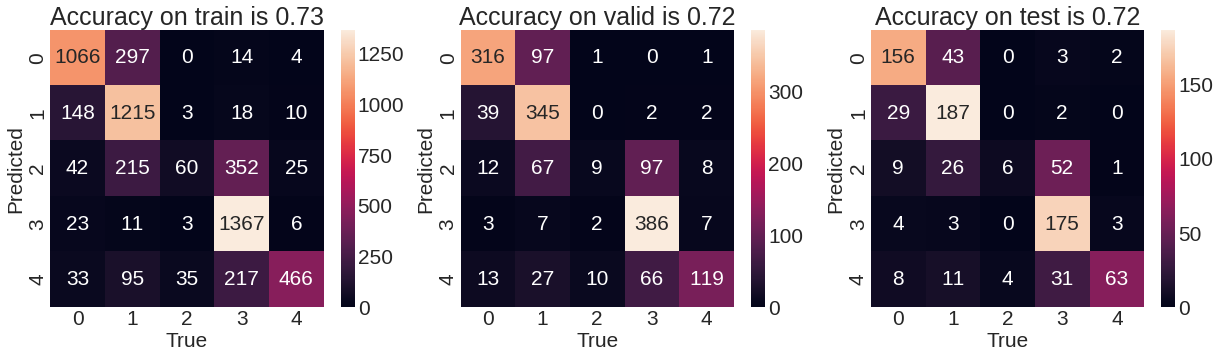

In [55]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(25, 6), dpi=60)

for i,split in enumerate(splits):
    
    y_true = predictions_2d_df[predictions_2d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_2d_df[predictions_2d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()



In [56]:
table = pd.pivot_table(df_mitocells[df_mitocells['split']=='test'], index="cell_stage", aggfunc="size")
print(table)

cell_stage
M0               204
M1M2             218
M3                94
M4M5             185
M6M7_complete    117
dtype: int64
